# Importing

In [1]:
# Importing
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag
import cvxpy as cp

import networkx as nx

from random import choice

from numpy.linalg import inv, pinv

import math

plt.rcParams.update({'font.size': 14})

# Constants for problem

In [5]:
d = 1000
p = 250
hi = 1e3 # число обусловленности матрицы K.T @ K
k = 1e4

We want to estimate a sparse vector $x^{*}$ with d = 1000, having 50 randomly chosen nonzero elements (equal to 1):

In [6]:
x_opt_approx = np.zeros(d)
nonzero_indeces = np.random.choice(1000, 50, replace = False)
x_opt_approx[nonzero_indeces] = 1

Matrix $\textbf{K}$ has random i.i.d. Gaussian elements and its nonzero singular values are modified so that they span the interval $\left[ \dfrac{1}{\sqrt\chi}, 1 \right]$ for some prescribed value of $\chi$.

In [7]:
sigmas = np.linspace(1/np.sqrt(hi), 1, p)
#sigmas = np.random.uniform(1/np.sqrt(hi), 1, p)
#zero_indeces = np.random.choice(250, 30, replace = False)
#sigmas[zero_indeces] = 0

def get_matrix(p, d, sigmas):
    """Returns p x d matrix with given min(p, d) singular values"""
    assert len(sigmas) == min(p, d)
    transpose = True 
    if p > d:
        p, d = d, p
        transpose = False 
    
    U = np.random.randn(d, d)
    Qd, _ = np.linalg.qr(U)
    K = Qd[:d, :p]
    K = K @ np.diag(sigmas)
    
    U = np.random.randn(p, p)
    Qp, _ = np.linalg.qr(U)
    
    A = K @ Qp
    if transpose:
        A = A.T
    return A

K = get_matrix(p, d, sigmas)

In [8]:
#K = np.diag(sigmas)
#K = np.hstack((K, np.zeros((p, d-p))))

In [9]:
b = K @ x_opt_approx

In [10]:
e = np.sqrt(1/(k-1))

def func(x_i):
    return np.sqrt(x_i**2 + e**2) + e / 2 * x_i**2

def F(x):
    return np.sum(np.array([func(x[i]) for i in range(len(x))]))

def grad_func(x_i):
    return x_i * (1 / np.sqrt(x_i**2 + e**2) + e)
    
def grad_F(x):
    return np.array([grad_func(x[i]) for i in range(len(x))])

# Solving via CVXPY

In [11]:
# проверка данных:
x = cp.Variable(d)

Func = 0

for i in range(d):
    Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
constraints = [K @ x == b]


obj = cp.Minimize(Func)

prob = cp.Problem(obj, constraints)
prob.solve()
x_CVXPY_opt = x.value

np.linalg.norm(x_CVXPY_opt - x_opt_approx)**2

c:\Users\kisnikser\anaconda3\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


0.4309559930111028

# Algorithm with Chebyshev acceleration implementation

In [13]:
# from theorem 2:
W = K.T @ K

eigenvalues = np.linalg.eigvalsh(W)

lmb1 = eigenvalues[::-1][0]
lmb2 = eigenvalues[::-1][p-1]

N = math.ceil(np.sqrt(hi))
tau = min(1, 1/2 * np.sqrt(19/(15 * k)))

L = 1/e + e
mu = e

eta = 1 / (4 * tau * L)
theta = 15 / (19 * eta)
alpha = mu

x0 = np.ones(d)

In [14]:
lmb1/lmb2

1000.0000000000196

In [15]:
def Chebyshev(z0, K, b, N, lmb1, lmb2):
    rho = (lmb1 - lmb2)**2 / 16
    nu = (lmb1 + lmb2) / 2
        
    z_k = np.zeros((N+1, d))
    z_k[0] = z0
    gamma = -nu / 2
    p = -K.T @ (K @ z_k[0] - b) / nu
    z_k[1] = z_k[0] + p
    for k in range(1, N):
        beta = rho / gamma
        gamma = -(nu + beta)
        p = (K.T @ (K @ z_k[k] - b) + beta * p) / gamma
        z_k[k+1] = z_k[k] + p
            
    return z_k[N]

In [16]:
def Salim(x0, N, tau, lmb1, lmb2, eta, theta, alpha, n_iter):
    x_k = np.zeros((n_iter, d))
    x_k_f = np.zeros((n_iter, d))
    u_k = np.zeros((n_iter, d))
    
    x_k[0] = x0
    x_k_f[0] = x0
    u_k[0] = np.zeros(d)
        
    k = 0
    
    while k <= n_iter-2:
        x_g = tau * x_k[k] + (1 - tau) * x_k_f[k]
        x_half = 1 / (1 + eta * alpha) * (x_k[k] - eta * (grad_F(x_g) - alpha * x_g + u_k[k]))
        r = theta * (x_half - Chebyshev(x_half, K, b, N, lmb1, lmb2))
        u_k[k+1] = u_k[k] + r
        x_k[k+1] = x_half - eta * 1 / (1 + eta * alpha) * r
        x_k_f[k+1] = x_g + 2 * tau / (2 - tau) * (x_k[k+1] - x_k[k])
        k += 1
    
    return x_k      

In [17]:
%%time
x_k = Salim(x0, N, tau, lmb1, lmb2, eta, theta, alpha, 4000)

CPU times: total: 1min 28s
Wall time: 22.5 s


# Comparison

Text(0, 0.5, 'Squared error')

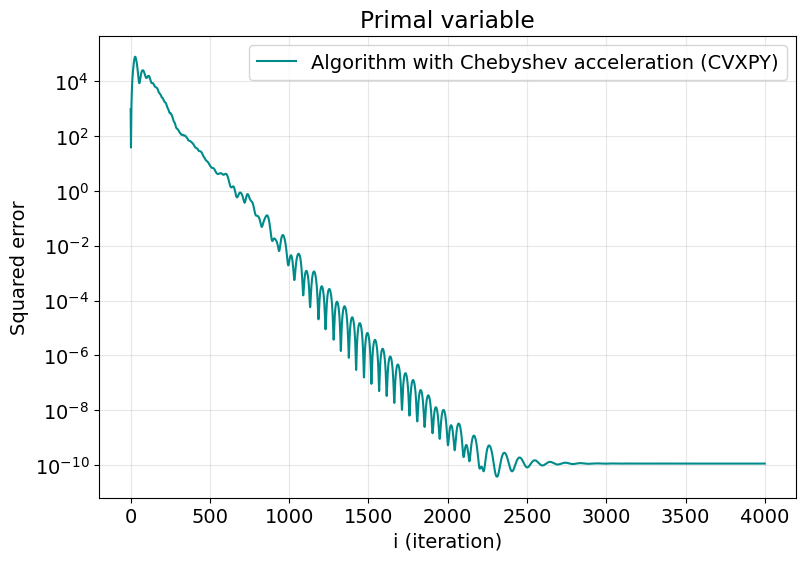

In [20]:
plt.figure(figsize=(9, 6))

#plt.plot(range(x_k.shape[0]), [np.linalg.norm(x_k[i] - x_opt_approx)**2 for i in range(x_k.shape[0])], 
#         label = 'Salims Algorithm', color = 'coral')

plt.plot(range(x_k.shape[0]), [np.linalg.norm(x_k[i] - x_CVXPY_opt)**2 for i in range(x_k.shape[0])], 
         label = 'Algorithm with Chebyshev acceleration (CVXPY)', color = 'darkcyan')

plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

# Intermediate Algorithm implementation

In [16]:
tau = min(1, 1/2 * np.sqrt(hi/k))
L = 1 / e + e
mu = e
eta = 1 / (4 * tau * L)
theta = 1 / (eta * lmb1)
alpha = mu

In [17]:
def Intermediate_Salim(x0, tau, eta, theta, alpha, n_iter):
    x_k = np.zeros((n_iter, d))
    x_k_f = np.zeros((n_iter, d))
    y_k = np.zeros((n_iter, p))
    
    x_k[0] = x0
    x_k_f[0] = x0
    y_k[0] = np.zeros(p)
    
    k = 0
    
    while k <= n_iter-2:
        x_g = tau * x_k[k] + (1 - tau) * x_k_f[k]
        x_half = 1 / (1 + eta * alpha) * (x_k[k] - eta * (grad_F(x_g) - alpha * x_g + K.T @ y_k[k]))
        y_k[k+1] = y_k[k] + theta * (K @ x_half - b)
        x_k[k+1] = 1 / (1 + eta * alpha) * (x_k[k] - eta * (grad_F(x_g) - alpha * x_g + K.T @ y_k[k+1]))
        x_k_f[k+1] = x_g + 2 * tau / (2 - tau) * (x_k[k+1] - x_k[k])
        k += 1
    
    return x_k      

In [18]:
%%time
x_k_I = Intermediate_Salim(x0, tau, eta, theta, alpha, 4000)

CPU times: total: 23.6 s
Wall time: 23.6 s


# Comparison

Text(0, 0.5, 'Squared error')

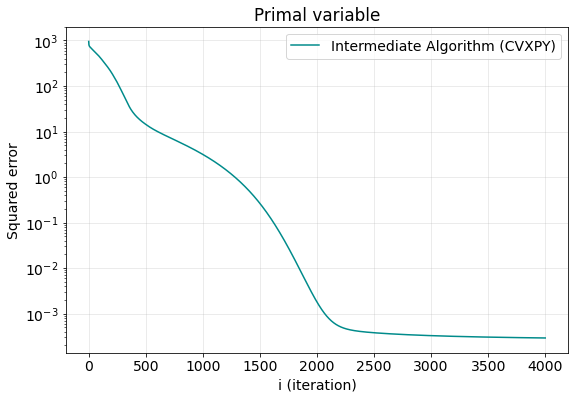

In [19]:
plt.figure(figsize=(9, 6))

#plt.plot(range(x_k_I.shape[0]), [np.linalg.norm(x_k_I[i] - x_opt_approx)**2 for i in range(x_k_I.shape[0])], 
         #label = 'Intermediate Salims Algorithm', color = 'coral')

plt.plot(range(x_k_I.shape[0]), [np.linalg.norm(x_k_I[i] - x_CVXPY_opt)**2 for i in range(x_k_I.shape[0])], 
         label = 'Intermediate Algorithm (CVXPY)', color = 'darkcyan')

plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

# Variation condition number of a function

## Algorithm with Chebyshev acceleration

CPU times: total: 41min 44s
Wall time: 41min 44s


Text(0, 0.5, 'Squared error')

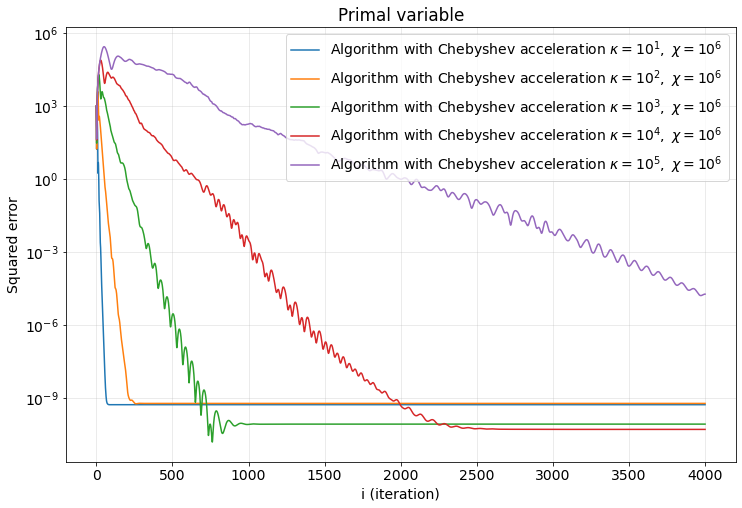

In [20]:
%%time
plt.figure(figsize=(12, 8))


for _ in range(1, 6):
    k = 10**_
    e = np.sqrt(1/(k-1))
    tau = min(1, 1/2 * np.sqrt(19/(15 * k)))

    L = 1/e + e
    mu = e

    eta = 1 / (4 * tau * L)
    theta = 15 / (19 * eta)
    alpha = mu
    
    # Solving via CVXPY
    x = cp.Variable(d)
    
    Func = 0

    for i in range(d):
        Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
    constraints = [K @ x == b]


    obj = cp.Minimize(Func)

    prob = cp.Problem(obj, constraints)
    prob.solve()
    x_CVXPY_opt = x.value
    
    
    x_k = Salim(x0, N, tau, lmb1, lmb2, eta, theta, alpha, 4000)
    
    plt.plot(range(x_k.shape[0]), [np.linalg.norm(x_k[i] - x_CVXPY_opt)**2 for i in range(x_k.shape[0])], 
         label = f'Algorithm with Chebyshev acceleration $\kappa = 10^{_},~\chi = 10^{6}$')
    
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

## Intermediate Algorithm

CPU times: total: 8min 13s
Wall time: 8min 13s


Text(0, 0.5, 'Squared error')

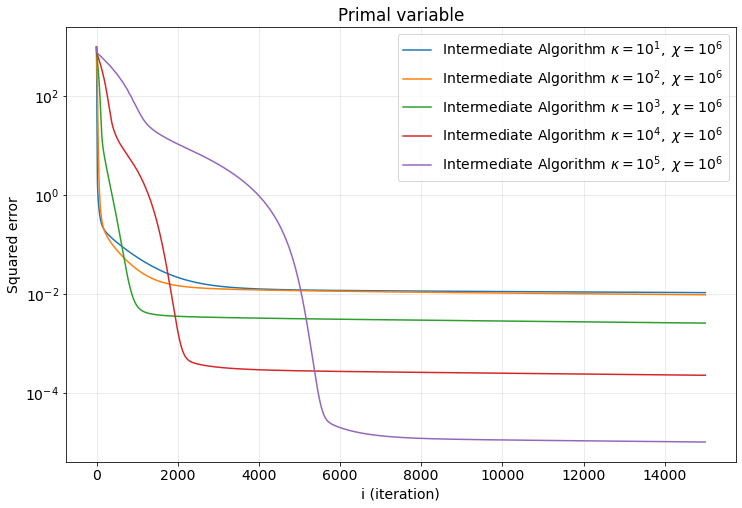

In [21]:
%%time
plt.figure(figsize=(12, 8))


for _ in range(1, 6):
    k = 10**_
    e = np.sqrt(1/(k-1))
    tau = min(1, 1/2 * np.sqrt(hi/k))
    L = 1 / e + e
    mu = e
    eta = 1 / (4 * tau * L)
    theta = 1 / (eta * lmb1)
    alpha = mu
    
    # Solving via CVXPY
    x = cp.Variable(d)
    
    Func = 0

    for i in range(d):
        Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
    constraints = [K @ x == b]


    obj = cp.Minimize(Func)

    prob = cp.Problem(obj, constraints)
    prob.solve()
    x_CVXPY_opt = x.value
    
    
    x_k_I = Intermediate_Salim(x0, tau, eta, theta, alpha, 15000)
    
    plt.plot(range(x_k_I.shape[0]), [np.linalg.norm(x_k_I[i] - x_CVXPY_opt)**2 for i in range(x_k_I.shape[0])], 
         label = f'Intermediate Algorithm $\kappa = 10^{_},~\chi = 10^{6}$')
    
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

# Variation condition number of a matrix K

## Algorithm with Chebyshev acceleration

CPU times: total: 5min 51s
Wall time: 5min 42s


Text(0, 0.5, 'Squared error')

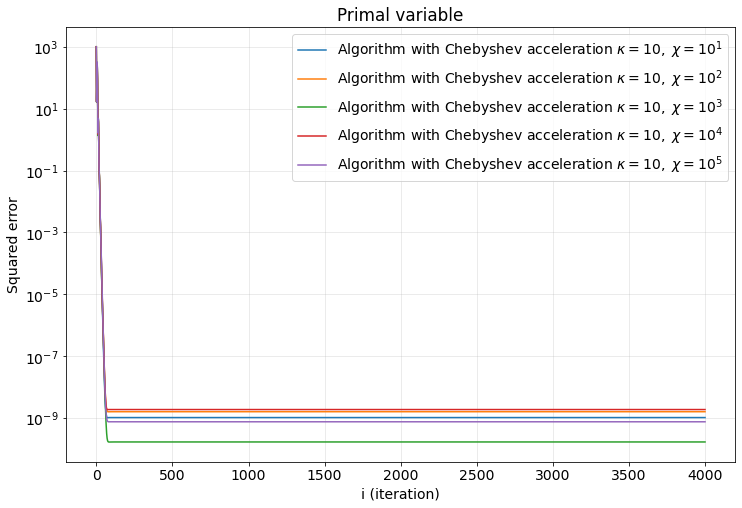

In [22]:
%%time
plt.figure(figsize=(12, 8))


for _ in range(1, 6):
    hi = 10**_
    k = 1e1
    
    sigmas = np.linspace(1/np.sqrt(hi), 1, p)
    K = get_matrix(p, d, sigmas)
    W = K.T @ K
    b = K @ x_opt_approx
    
    eigenvalues = np.linalg.eigvalsh(W)

    lmb1 = eigenvalues[::-1][0]
    lmb2 = eigenvalues[::-1][p-1]

    N = math.ceil(np.sqrt(hi))
    
    e = np.sqrt(1/(k-1))
    tau = min(1, 1/2 * np.sqrt(19/(15 * k)))

    L = 1/e + e
    mu = e

    eta = 1 / (4 * tau * L)
    theta = 15 / (19 * eta)
    alpha = mu
    
    # Solving via CVXPY
    x = cp.Variable(d)
    
    Func = 0

    for i in range(d):
        Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
    constraints = [K @ x == b]


    obj = cp.Minimize(Func)

    prob = cp.Problem(obj, constraints)
    prob.solve()
    x_CVXPY_opt = x.value
    
    
    x_k = Salim(x0, N, tau, lmb1, lmb2, eta, theta, alpha, 4000)
    
    plt.plot(range(x_k.shape[0]), [np.linalg.norm(x_k[i] - x_CVXPY_opt)**2 for i in range(x_k.shape[0])], 
         label = f'Algorithm with Chebyshev acceleration $\kappa = 10,~\chi = 10^{_}$')
    
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

CPU times: total: 5min 51s
Wall time: 5min 42s


Text(0, 0.5, 'Squared error')

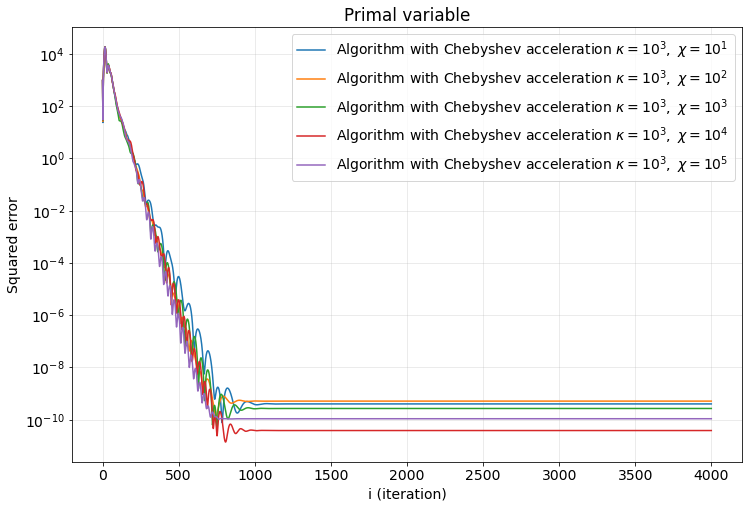

In [23]:
%%time
plt.figure(figsize=(12, 8))


for _ in range(1, 6):
    hi = 10**_
    k = 1e3
    
    sigmas = np.linspace(1/np.sqrt(hi), 1, p)
    K = get_matrix(p, d, sigmas)
    W = K.T @ K
    b = K @ x_opt_approx
    
    eigenvalues = np.linalg.eigvalsh(W)

    lmb1 = eigenvalues[::-1][0]
    lmb2 = eigenvalues[::-1][p-1]

    N = math.ceil(np.sqrt(hi))
    
    e = np.sqrt(1/(k-1))
    tau = min(1, 1/2 * np.sqrt(19/(15 * k)))

    L = 1/e + e
    mu = e

    eta = 1 / (4 * tau * L)
    theta = 15 / (19 * eta)
    alpha = mu
    
    # Solving via CVXPY
    x = cp.Variable(d)
    
    Func = 0

    for i in range(d):
        Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
    constraints = [K @ x == b]


    obj = cp.Minimize(Func)

    prob = cp.Problem(obj, constraints)
    prob.solve()
    x_CVXPY_opt = x.value
    
    
    x_k = Salim(x0, N, tau, lmb1, lmb2, eta, theta, alpha, 4000)
    
    plt.plot(range(x_k.shape[0]), [np.linalg.norm(x_k[i] - x_CVXPY_opt)**2 for i in range(x_k.shape[0])], 
         label = f'Algorithm with Chebyshev acceleration $\kappa = 10^{3},~\chi = 10^{_}$')
    
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

## Intermediate Algorithm

CPU times: total: 8min 18s
Wall time: 8min 11s


Text(0, 0.5, 'Squared error')

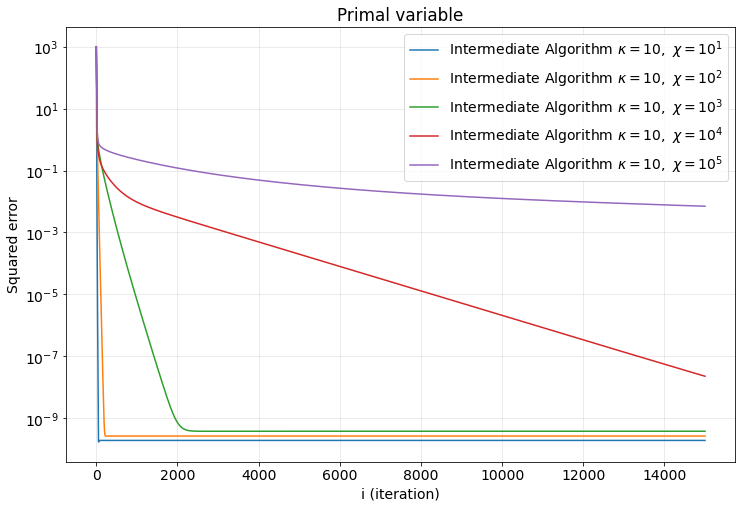

In [24]:
%%time
plt.figure(figsize=(12, 8))


for _ in range(1, 6):
    hi = 10**_
    k = 1e1
    sigmas = np.linspace(1/np.sqrt(hi), 1, p)
    K = get_matrix(p, d, sigmas)
    W = K.T @ K
    b = K @ x_opt_approx
    e = np.sqrt(1/(k-1))
    tau = min(1, 1/2 * np.sqrt(hi/k))
    L = 1 / e + e
    mu = e
    eta = 1 / (4 * tau * L)
    theta = 1 / (eta * lmb1)
    alpha = mu
    
    # Solving via CVXPY
    x = cp.Variable(d)
    
    Func = 0

    for i in range(d):
        Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
    constraints = [K @ x == b]


    obj = cp.Minimize(Func)

    prob = cp.Problem(obj, constraints)
    prob.solve()
    x_CVXPY_opt = x.value
    
    
    x_k_I = Intermediate_Salim(x0, tau, eta, theta, alpha, 15000)
    
    plt.plot(range(x_k_I.shape[0]), [np.linalg.norm(x_k_I[i] - x_CVXPY_opt)**2 for i in range(x_k_I.shape[0])], 
         label = f'Intermediate Algorithm $\kappa = 10,~\chi = 10^{_}$')
    
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

CPU times: total: 8min 26s
Wall time: 8min 19s


Text(0, 0.5, 'Squared error')

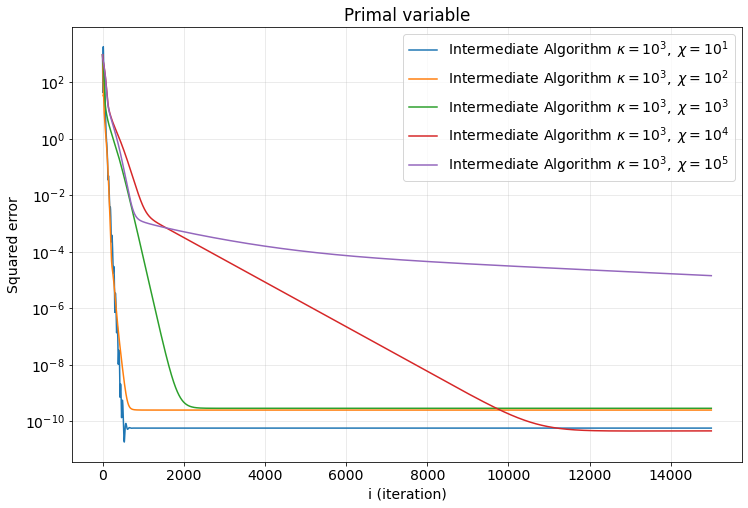

In [25]:
%%time
plt.figure(figsize=(12, 8))


for _ in range(1, 6):
    hi = 10**_
    k = 1e3
    sigmas = np.linspace(1/np.sqrt(hi), 1, p)
    K = get_matrix(p, d, sigmas)
    W = K.T @ K
    b = K @ x_opt_approx
    e = np.sqrt(1/(k-1))
    tau = min(1, 1/2 * np.sqrt(hi/k))
    L = 1 / e + e
    mu = e
    eta = 1 / (4 * tau * L)
    theta = 1 / (eta * lmb1)
    alpha = mu
    
    # Solving via CVXPY
    x = cp.Variable(d)
    
    Func = 0

    for i in range(d):
        Func += cp.norm(cp.hstack([x[i], e])) + e / 2 * x[i]**2
    
    constraints = [K @ x == b]


    obj = cp.Minimize(Func)

    prob = cp.Problem(obj, constraints)
    prob.solve()
    x_CVXPY_opt = x.value
    
    
    x_k_I = Intermediate_Salim(x0, tau, eta, theta, alpha, 15000)
    
    plt.plot(range(x_k_I.shape[0]), [np.linalg.norm(x_k_I[i] - x_CVXPY_opt)**2 for i in range(x_k_I.shape[0])], 
         label = f'Intermediate Algorithm $\kappa = 10^{3},~\chi = 10^{_}$')
    
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")